In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

x_train, tokenizer_en = load_data('./data/small_parallel_enja/train.en')
y_train, tokenizer_ja = load_data('./data/small_parallel_enja/train.ja')

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.02, random_state=42)

x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

seqX_len = len(x_train[0])
seqY_len = len(y_train[0])

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Permute, Activation, Embedding, Dense, LSTM, concatenate, dot
from tensorflow.keras import backend as K

emb_dim = 256
hid_dim = 256
att_dim = 256

encoder_inputs = Input(shape=(seqX_len,))
encoder_embedded = Embedding(en_vocab_size, emb_dim, mask_zero=True)(encoder_inputs)
encoded_seq, *encoder_states = LSTM(hid_dim, return_sequences=True, return_state=True)(encoder_embedded)

decoder_inputs = Input(shape=(seqY_len,))
decoder_embedding = Embedding(ja_vocab_size, emb_dim)
decoder_embedded = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True)
decoded_seq, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)

score_dense = Dense(hid_dim)
score = score_dense(decoded_seq)                        # shape: (seqY_len, hid_dim) -> (seqY_len, hid_dim)
score = dot([score, encoded_seq], axes=(2,2))           # shape: [(seqY_len, hid_dim), (seqX_len, hid_dim)] -> (seqY_len, seqX_len)
attention = Activation('softmax')(score)                # shape: (seqY_len, seqX_len) -> (seqY_len, seqX_len)
context = dot([attention, encoded_seq], axes=(2,1))     # shape: [(seqY_len, seqX_len), (seqX_len, hid_dim)] -> (seqY_len, hid_dim)
concat = concatenate([context, decoded_seq], axis=2)    # shape: [(seqY_len, hid_dim), (seqY_len, hid_dim)] -> (seqY_len, 2*hid_dim)
attention_dense = Dense(att_dim, activation='tanh')
attentional = attention_dense(concat)                   # shape: (seqY_len, 2*hid_dim) -> (seqY_len, att_dim)
output_dense = Dense(ja_vocab_size, activation='softmax')
outputs = output_dense(attentional)                     # shape: (seqY_len, att_dim) -> (seqY_len, ja_vocab_size)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

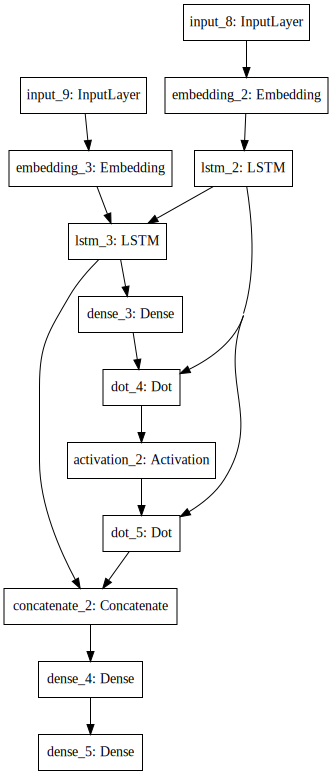

In [10]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 18, 256)      1699072     input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 18, 256)      2246912     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LS

In [12]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 39200 samples, validate on 9800 samples
Epoch 1/10
39200/39200 [==============================] - 63s 2ms/sample - loss: 2.9737 - val_loss: 2.3334
Epoch 2/10
39200/39200 [==============================] - 67s 2ms/sample - loss: 2.1277 - val_loss: 1.9983
Epoch 3/10
39200/39200 [==============================] - 69s 2ms/sample - loss: 1.8595 - val_loss: 1.8142
Epoch 4/10
39200/39200 [==============================] - 73s 2ms/sample - loss: 1.6763 - val_loss: 1.6660
Epoch 5/10
39200/39200 [==============================] - 78s 2ms/sample - loss: 1.5266 - val_loss: 1.5481
Epoch 6/10
39200/39200 [==============================] - 82s 2ms/sample - loss: 1.3960 - val_loss: 1.4431
Epoch 7/10
39200/39200 [==============================] - 88s 2ms/sample - loss: 1.2819 - val_loss: 1.3726
Epoch 8/10
39200/39200 [==============================] - 91s 2ms/sample - loss: 1.1827 - val_loss: 1.3126
Epoch 9/10
39200/39200 [==============================] - 97s 2ms/sample - loss: 1.0989 - val_l

In [13]:
encoder_model = Model(encoder_inputs, [encoded_seq]+encoder_states)

decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]

decoder_inputs = Input(shape=(1,))
decoder_embedded = decoder_embedding(decoder_inputs)
decoded_seq, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoded_seq] + decoder_states)

encoded_seq_in, decoded_seq_in = Input(shape=(seqX_len, hid_dim)), Input(shape=(1, hid_dim))
score = score_dense(decoded_seq_in)
score = dot([score, encoded_seq_in], axes=(2,2))
attention = Activation('softmax')(score)
context = dot([attention, encoded_seq_in], axes=(2,1))
concat = concatenate([context, decoded_seq_in], axis=2)
attentional = attention_dense(concat)
attention_outputs = output_dense(attentional)

attention_model = Model([encoded_seq_in, decoded_seq_in], [attention_outputs, attention])

In [14]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    encoded_seq, *states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])
    output_seq = bos_eos[0][:]
    attention_seq = np.empty((0,len(input_seq[0])))
    
    while True:
        decoded_seq, *states_value = decoder_model.predict([target_seq] + states_value)
        output_tokens, attention = attention_model.predict([encoded_seq, decoded_seq])
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        attention_seq = np.append(attention_seq, attention[0], axis=0)
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq, attention_seq

In [24]:
%matplotlib inline 
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

text_no = 0
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

output_seq, attention_seq = decode_sequence(input_seq, bos_eos)
prediction = [detokenizer_ja[i] for i in output_seq]
reference = [detokenizer_ja[i] for i in y_test[text_no]]

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join(prediction))
print('正解文:', ' '.join(reference))
print('BLEU:', sentence_bleu(reference, prediction))

元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> 東京 で は 、 車 を 持 っ て い い で す よ 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>
BLEU: 1.459387436556547e-231


C:\Users\suizh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\suizh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\suizh\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

In [25]:
text_no = 1
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')

output_seq, attention_seq = decode_sequence(input_seq, bos_eos)
prediction = [detokenizer_ja[i] for i in output_seq]
reference = [detokenizer_ja[i] for i in y_test[text_no]]

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join(prediction))
print('正解文:', ' '.join(reference))
print('BLEU:', sentence_bleu(reference, prediction))

元の文: <s> i study at school . </s>
生成文: <s> 私 は 学校 に 勉強 し ま す 。 </s>
正解文: <s> 私 は 学校 で 勉強 する 。 </s>
BLEU: 1.4147351699132998e-231


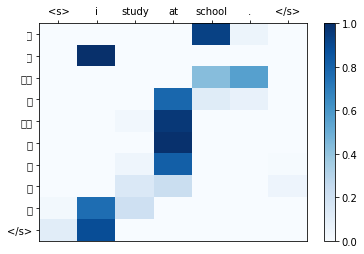

In [26]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(attention_seq[:,:len(x_test[text_no])], cmap=plt.cm.Blues, vmax=1)
ax.set_xticks(np.arange(len(x_test[text_no])) + 0.5, minor=False)
ax.set_yticks(np.arange(attention_seq.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels([detokenizer_en[i] for i in x_test[text_no]], minor=False)
ax.set_yticklabels([detokenizer_ja[i] for i in output_seq[1:]], minor=False)
plt.colorbar(heatmap)
plt.show()